### Example script to extract event wise information as a array from `DistributionMaker()`

Import the necessary dependencies and functions from PISA

In [1]:
import os, sys, collections
import numpy as np
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt
import copy
import pisa
from pisa.core.distribution_maker import DistributionMaker
from pisa.core.pipeline import Pipeline
from pisa.analysis.analysis import Analysis
from pisa import FTYPE, ureg

%matplotlib inline

<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


## Model
We can now instantiate the `model` (given our configs) using a  `Pipeline` in a `DistributionMaker`corresponds to neutrinos.

In [2]:
model = DistributionMaker(["settings/pipeline/IceCube_3y_neutrinos.cfg"])

The neutrino pipline consist of the following stages
- csv_loader/data_loader - Loads the data/MC
- honda_ip - Applying flux model
- barr_simple - Applying flux uncertainities
- prob3 - Applying probability of neutrino oscillation 
- aeff - Livetime of the detector and the normalization of neutrino events
- hist - Converts events into histogram
- hypersurface - Handles nuisance parameters related to detector

In [5]:
model.pipelines[0]

stage number,name,calc_mode,apply_mode,has setup,has compute,has apply,# fixed params,# free params
0,csv_loader,events,events,True,False,True,0,0
1,honda_ip,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,False,1,0
2,barr_simple,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,False,1,4
3,prob3,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,True,9,3
4,aeff,events,events,False,False,True,2,3
5,hist,events,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",True,False,True,0,0
6,hypersurfaces,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)","""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",True,True,True,0,5


In the following cell, 
- We are removing the `hist` stage, which converts the events into binned histograms by applying weights 
- Changing the `hypersurface` `apply_mode` to `events` from `binning mode`

In [6]:
for pipeline in model.pipelines:
    
    analysis_binning = pipeline.output_binning
    
    for i, stage in enumerate(pipeline._stages) :
            if stage.service_name in [ "hist"] :
                pipeline._stages.pop(i)
                break
          
    for stage in pipeline._stages :
            if stage.service_name == 'hypersurfaces' :
                stage.apply_mode = "events"

    return_items = [ model, analysis_binning ]    

`stages` after modification

In [10]:
model.pipelines[0]

stage number,name,calc_mode,apply_mode,has setup,has compute,has apply,# fixed params,# free params
0,csv_loader,events,events,True,False,True,0,0
1,honda_ip,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,False,1,0
2,barr_simple,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,False,1,4
3,prob3,"""true_allsky_fine"": 200 (true_energy) x 200 (true_coszen)",events,True,True,True,9,3
4,aeff,events,events,False,False,True,2,3
5,hypersurfaces,"""dragon_datarelease"": 8 (reco_energy) x 8 (reco_coszen) x 2 (pid)",events,True,True,True,0,5


Run the model to process the updated changes

In [7]:
model.run()

Output ContainerSet contains the eventwise information of 'nue_cc', 'numu_cc', 'nutau_cc', 'nue_nc', 'numu_nc', 'nutau_nc', 'nuebar_cc', 'numubar_cc', 'nutaubar_cc', 'nuebar_nc', 'numubar_nc', 'nutaubar_nc'

In [12]:
model.pipelines[0].data

ContainerSet containing ['nue_cc', 'numu_cc', 'nutau_cc', 'nue_nc', 'numu_nc', 'nutau_nc', 'nuebar_cc', 'numubar_cc', 'nutaubar_cc', 'nuebar_nc', 'numubar_nc', 'nutaubar_nc']

In [13]:
templates = []
for p in model.pipelines:
    templates.append(p.data)

List of variables that we are interested

In [14]:
nu_variables = ['true_energy', 'true_coszen', 'weighted_aeff', 'reco_energy', 'reco_coszen', 'pid', 'weights', 'initial_weights']

In the following cell we are combining all the neutral current events under the key `nu_nc`, also we are combining neutrino and anti-neutrino events together in a dictionary named `events`

In [15]:
events = collections.OrderedDict()
events["nu_nc"]=collections.OrderedDict()
events["nue_cc"]=collections.OrderedDict()
events["numu_cc"]=collections.OrderedDict()
events["nutau_cc"]=collections.OrderedDict()

for container_set in templates:    
    for container in container_set:
        
        key_name = container.name
        
        if "nue" in key_name and "nc" not in key_name:
            for key in nu_variables:

                if key not in events['nue_cc'].keys():
                    events["nue_cc"][key] = container[key]
                else:
                    events["nue_cc"][key] = np.append(events["nue_cc"][key], container[key])

        elif "numu" in key_name and "nc" not in key_name:
            for key in nu_variables:

                if key not in events['numu_cc'].keys():
                    events["numu_cc"][key] = container[key]
                else:
                    events["numu_cc"][key] = np.append(events["numu_cc"][key], container[key])
                    
                    
        elif "nutau" in key_name and "nc" not in key_name:
            for key in nu_variables:

                if key not in events['nutau_cc'].keys():
                    events["nutau_cc"][key] = container[key]
                else:
                    events["nutau_cc"][key] = np.append(events["nutau_cc"][key], container[key])
        
        elif "_nc" in key_name:
            for key in nu_variables:

                if key not in events['nu_nc'].keys():
                    events["nu_nc"][key] = container[key]
                else:
                    events["nu_nc"][key] = np.append(events["nu_nc"][key], container[key])


Following celles demonstrates the example plots (True and Reconstructed energy distribution of neutrinos)

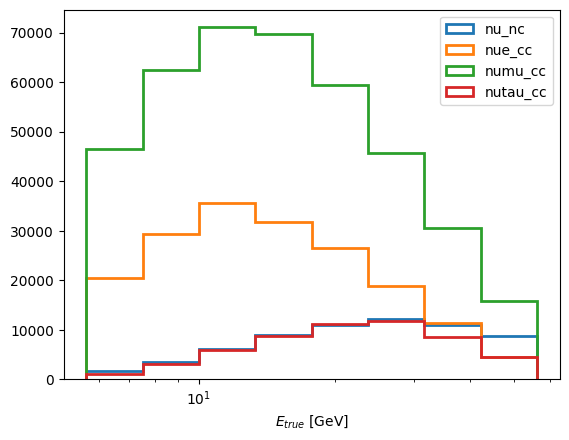

In [36]:
energy_bin = return_items[1].dimensions[0].bin_edges.m

for particle_key in events.keys():
        plt.hist(events[particle_key]['true_energy'], bins = energy_bin, histtype='step',label = particle_key, linewidth=2, alpha=1, stacked=True)
plt.legend()
plt.xlabel(r'$E_{true}$ [GeV]')
plt.xscale("log")
plt.show()

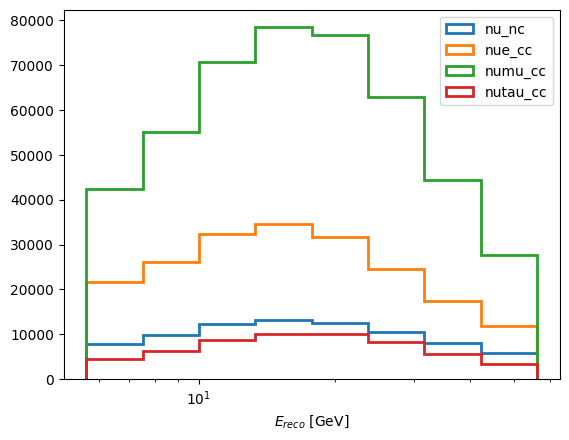

In [37]:
energy_bin = return_items[1].dimensions[0].bin_edges.m

for particle_key in events.keys():
        plt.hist(events[particle_key]['reco_energy'], bins = energy_bin, histtype='step', label = particle_key, linewidth=2, alpha=1, stacked=True)

plt.legend()
plt.xlabel(r'$E_{reco}$ [GeV]')
plt.xscale("log")
plt.show()